<a href="https://colab.research.google.com/github/EnricoHuber/POS-Tagging-Classification/blob/main/NLP_Project_POS_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
# Importing useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import requests
import string
import pickle

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from google.colab import drive

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [127]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
filepath = '/content/drive/MyDrive/NLP/PROGETTO INTERCORSO/Datasets/italian_training_10000.utf8'

In [129]:
def get_num_lines(filepath):
  with open(filepath) as my_file:
    return sum(1 for _ in my_file)

In [130]:
file_lines = get_num_lines(filepath)
file_lines

10000

In [131]:
def get_sentences(line_length, filepath, language):
  tokens = []
  if language == 'eng':
    tag_column = 2
  elif language == 'ita':
    tag_column = 3
  sentences = []
  with open(filepath, 'r') as file:
    """preprocessing"""
    sentence = []
    for line in file:
      line = str.split(str.strip(line))
      if len(line) == line_length:
        token, pos_tag = line[0], line[tag_column]
        tokens.append(token)
        sentence.append((token, pos_tag))
        continue
      sentences.append(sentence)
      sentence = []
    return sentences, tokens

In [132]:
corpus, tokens = get_sentences(7, filepath, 'ita')    # Use 'eng' instead of 'ita' and 3 instead of 7 for using the english corpus

In [133]:
tokens

['Davide',
 'Guglielmini',
 ',',
 'finito',
 'agli',
 'arresti',
 'domiciliari',
 'assieme',
 'ad',
 'altre',
 'quattro',
 'persone',
 ',',
 'hanno',
 'presentato',
 'alla',
 'Procura',
 'una',
 'documentazione',
 'composta',
 'da',
 'planimetrie',
 'e',
 'documenti',
 'nella',
 'quale',
 'si',
 'spiega',
 'che',
 'la',
 'situazione',
 'dei',
 'bagni',
 'e',
 'dei',
 'privè',
 'sarebbe',
 'radicalmente',
 'cambiata',
 '(',
 '...',
 ')',
 'i',
 'bagni',
 'non',
 'si',
 'trovano',
 'più',
 "all'",
 'interno',
 'del',
 'locale',
 ',',
 'ma',
 'fuori',
 ';',
 'anche',
 'la',
 'zona',
 'adibita',
 'a',
 'privè',
 'è',
 'stata',
 'modificata',
 '.',
 'Due',
 'elementi',
 'importanti',
 ',',
 'perché',
 'era',
 'appunto',
 'nei',
 'bagni',
 'e',
 'nel',
 'privè',
 'che',
 'i',
 'clienti',
 ',',
 'vip',
 'e',
 'persone',
 'comuni',
 ',',
 'consumavano',
 'cocaina',
 ',',
 'come',
 'documentato',
 'dalle',
 '«',
 'cimici',
 '»',
 'piazzate',
 'nel',
 '2007',
 'dalla',
 'polizia',
 '(',
 'guarda

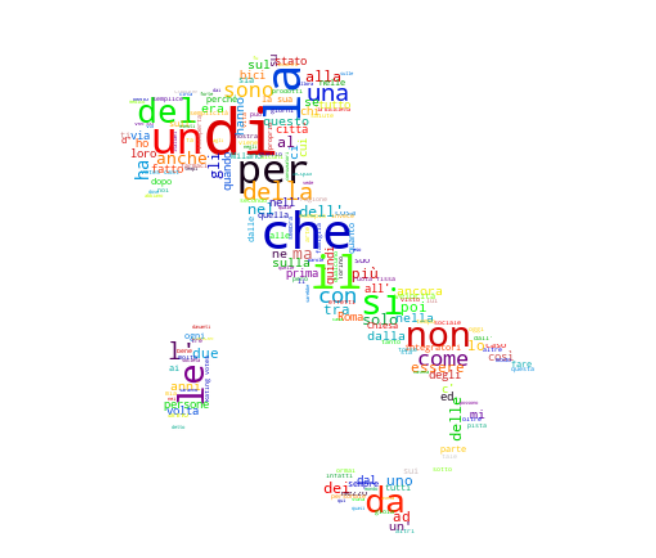

In [134]:
stopwords = set(STOPWORDS)

italy_mask = np.array(Image.open('/content/drive/MyDrive/NLP/PROGETTO INTERCORSO/Italia.png'))
wordcloud = WordCloud(width=2000, height=1200, colormap='nipy_spectral', background_color='white', margin=-2, stopwords=stopwords, mask=italy_mask).generate(' '.join(tokens))
plt.figure(figsize=((20, 10)))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.savefig('/content/drive/MyDrive/NLP/PROGETTO INTERCORSO/WordCloud.png')
plt.show()

In [135]:
def remove_blanklines(corpus_raw):
  """
  Since our corpus had blank lines, we should remove them, otherwise we would have empty lists as sentences
  """
  corpus_clean = [x for x in corpus if x]
  return corpus_clean

In [136]:
corpus_clean = remove_blanklines(corpus)

In [137]:
# In order to check if we actually removed some lines. If False then yes, we did it!
len(corpus_clean) is len(corpus)

False

In [138]:
def corpus_train_test_split(corpus, split=0.8):
  random.shuffle(corpus)
  step = len(corpus)*split
  corpus_train, corpus_test = corpus[:int(step)], corpus[int(step):]
  return corpus_train, corpus_test

In [139]:
corpus_train, corpus_test = corpus_train_test_split(corpus_clean)

In [140]:
len(corpus_train), len(corpus_test), len(corpus_clean), (len(corpus_train) + len(corpus_test) is len(corpus_clean))

(305, 77, 382, False)

In [141]:
def get_features(token, token_index, sentence):
  token_feature = {
      'token'                     : token,
      'is_first'                  : token_index == 0,
      'is_last'                   : token_index == len(sentence) - 1,
      'is_capitalized'            : token[0].upper() == token[0],
      'is_all_capitalized'        : token.upper() == token,
      'is_capitals_inside'        : token[1:].lower() != token[1:],

      'prefix-1'                  : token[0],
      'prefix-2'                  : '' if len(token) < 2 else token[:1],

      'suffix-1'                  : token[len(token)-1],
      'suffix-2'                  : '' if len(token) < 2 else token[-2:],
      
      'prev-token'                : '' if token_index == 0 else sentence[token_index - 1][0],
      '2-prev-token'              : '' if token_index <= 1 else sentence[token_index - 2][0],

      'next-token'                : '' if token_index == len(sentence) - 1 else sentence[token_index + 1][0],
      '2-next-token'              : '' if token_index >= len(sentence) - 2 else sentence[token_index + 2][0]
  }
  return token_feature

In [142]:
def get_features(token, token_index, sentence):
  token_feature = {
      'token'                     : token,
      'is_first'                  : token_index == 0,
      'is_last'                   : token_index == len(sentence) - 1,
      'is_capitalized'            : token[0].upper() == token[0],
      'is_all_capitalized'        : token.upper() == token,
      'is_capitals_inside'        : token[1:].lower() != token[1:],

      'prefix-1'                  : token[0],
      'prefix-2'                  : '' if len(token) < 2 else token[:2],
      'prefix-3'                  : '' if len(token) < 3 else token[:3],
      'prefix-4'                  : '' if len(token) < 4 else token[:4],
      'prefix-5'                  : '' if len(token) < 5 else token[:5],

      'suffix-1'                  : token[len(token)-1],
      'suffix-2'                  : '' if len(token) < 2 else token[-2:],
      'suffix-3'                  : '' if len(token) < 3 else token[-3:],
      'suffix-4'                  : '' if len(token) < 4 else token[-4:],
      'suffix-5'                  : '' if len(token) < 5 else token[-5:],

      'has-digits'                : True if [True for char in token if char in string.digits] else False,
      
      'prev-token'                : '' if token_index == 0 else sentence[token_index - 1][0],
      '2-prev-token'              : '' if token_index <= 1 else sentence[token_index - 2][0],
      'prev-token-samelast'       : False if token_index == 0 or sentence[token_index - 1][0][-1].lower() != token[-1].lower() else True,
      'succ-token-samelast'       : False if token_index == len(sentence)-1 or sentence[token_index + 1][0][-1].lower() != token[-1].lower() else True,

      'next-token'                : '' if token_index == len(sentence) - 1 else sentence[token_index + 1][0],
      '2-next-token'              : '' if token_index >= len(sentence) - 2 else sentence[token_index + 2][0]
  }
  return token_feature

In [143]:
def extract_features(all_sentences):
    features   = []                                                     # This is our x_train
    pos_labels = []                                                     # This is our y_train
    for sentence in all_sentences:
        for token_index, token_pair in enumerate(sentence):
            token       = token_pair[0]                                 # Get token
            features.append(get_features(token, token_index, sentence)) # Extract features from token and append it to features list (x_train)
            pos_label = token_pair[1]                                   # Get ground truth (golden) pos label of token
            pos_labels.append(pos_label)                                # Append pos label to pos_labels list (y_train) 

    return features, pos_labels    

In [144]:
features_train, pos_labels_train = extract_features(corpus_train)

In [145]:
features_test, pos_labels_test = extract_features(corpus_test)

In [146]:
features_train

[{'2-next-token': '"',
  '2-prev-token': '',
  'has-digits': False,
  'is_all_capitalized': True,
  'is_capitalized': True,
  'is_capitals_inside': False,
  'is_first': True,
  'is_last': False,
  'next-token': 'Qui',
  'prefix-1': '"',
  'prefix-2': '',
  'prefix-3': '',
  'prefix-4': '',
  'prefix-5': '',
  'prev-token': '',
  'prev-token-samelast': False,
  'succ-token-samelast': False,
  'suffix-1': '"',
  'suffix-2': '',
  'suffix-3': '',
  'suffix-4': '',
  'suffix-5': '',
  'token': '"'},
 {'2-next-token': ',',
  '2-prev-token': '',
  'has-digits': False,
  'is_all_capitalized': False,
  'is_capitalized': True,
  'is_capitals_inside': False,
  'is_first': False,
  'is_last': False,
  'next-token': '"',
  'prefix-1': 'Q',
  'prefix-2': 'Qu',
  'prefix-3': 'Qui',
  'prefix-4': '',
  'prefix-5': '',
  'prev-token': '"',
  'prev-token-samelast': False,
  'succ-token-samelast': False,
  'suffix-1': 'i',
  'suffix-2': 'ui',
  'suffix-3': 'Qui',
  'suffix-4': '',
  'suffix-5': '',
  't

In [147]:
def tag_occurencies(tag_list):
  tag_dict = {}
  for tag in tag_list:
    if tag not in tag_dict:
      tag_dict[tag] = 1
    else:
      tag_dict[tag] += 1
  return tag_dict

In [148]:
np.unique(pos_labels_train), len(list(np.unique(pos_labels_train)))

(array(['A', 'AP', 'B', 'BN', 'CC', 'CS', 'DD', 'DI', 'DQ', 'E', 'EA',
        'FB', 'FC', 'FF', 'FS', 'I', 'N', 'NO', 'PC', 'PD', 'PE', 'PI',
        'PP', 'PQ', 'PR', 'RD', 'RI', 'S', 'SA', 'SP', 'SW', 'T', 'V',
        'VA', 'VM', 'X'], dtype='<U2'), 36)

In [149]:
tag_occurencies(pos_labels_train)

{'A': 503,
 'AP': 57,
 'B': 362,
 'BN': 69,
 'CC': 249,
 'CS': 86,
 'DD': 33,
 'DI': 36,
 'DQ': 3,
 'E': 752,
 'EA': 465,
 'FB': 235,
 'FC': 50,
 'FF': 372,
 'FS': 295,
 'I': 1,
 'N': 151,
 'NO': 12,
 'PC': 154,
 'PD': 32,
 'PE': 21,
 'PI': 46,
 'PP': 2,
 'PQ': 1,
 'PR': 123,
 'RD': 439,
 'RI': 167,
 'S': 1561,
 'SA': 8,
 'SP': 354,
 'SW': 59,
 'T': 8,
 'V': 830,
 'VA': 134,
 'VM': 32,
 'X': 6}

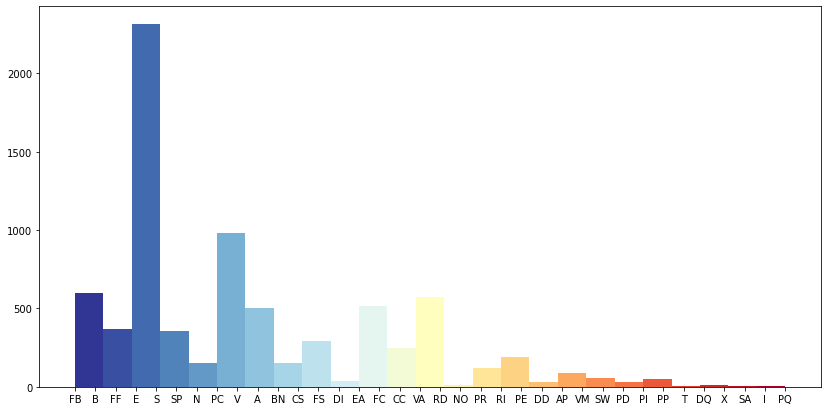

In [150]:
# This is  the colormap I'd like to use.
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=((14, 7)))
# Plot histogram.
n, bins, patches = plt.hist(pos_labels_train, 25, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.savefig('/content/drive/MyDrive/NLP/PROGETTO INTERCORSO/POS_LabelsHist.png')
plt.show()

### Training and Evaluating the models

In [151]:
t0 = time.time()
vectorizer = DictVectorizer(sparse=True)
data_vect = vectorizer.fit_transform(features_train)
print(f'Vectorization elapsed in {time.time() - t0:.2f} s')

Vectorization elapsed in 0.24 s


In [152]:
data_vect, data_vect.shape

(<7708x21926 sparse matrix of type '<class 'numpy.float64'>'
 	with 177284 stored elements in Compressed Sparse Row format>, (7708, 21926))

In [153]:
scores = {}
computational_costs = {}
fold = 5

In [154]:
import warnings
warnings.filterwarnings("ignore")

In [155]:
model_name = 'LogisticRegression'
lr = LogisticRegression(solver='liblinear')
t0 = time.time()
score_log = scores[model_name] = np.mean(cross_val_score(lr, data_vect, pos_labels_train, cv=fold, verbose=100, n_jobs=-1))
comput_time = (time.time()-t0)
computational_costs[model_name] = comput_time
print('\n' + f'Training/Testing of {model_name} with {fold} fold done in {comput_time:.2f} s', f'Score is {score_log}', sep = '\t|\t')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s finished

Training/Testing of LogisticRegression with 5 fold done in 8.70 s	|	Score is 0.8772703055522589


In [156]:
lr.fit(data_vect, pos_labels_train)
model_pickle = model_name + str(file_lines) + '.pkl'
with open(model_pickle, 'wb') as file:
  pickle.dump(lr, file)

In [158]:
model_name = 'OvR SVC'
ovr_clf = OneVsRestClassifier(SVC())
t0 = time.time()
score_ovr_clf = scores[model_name] = np.mean(cross_val_score(ovr_clf, data_vect, pos_labels_train, cv=fold, verbose=100, n_jobs=-1))
comput_time = (time.time()-t0)
computational_costs[model_name] = comput_time
print('\n' + f'Training/Testing of {model_name} with {fold} fold done in {comput_time:.2f} s', f'Score is {score_ovr_clf}', sep = '\t|\t')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.3min remaining:   53.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished

Training/Testing of OvR SVC with 5 fold done in 105.61 s	|	Score is 0.8663718288947748


In [159]:
ovr_clf.fit(data_vect, pos_labels_train)
model_pickle = model_name + str(file_lines) + '.pkl'
with open(model_pickle, 'wb') as file:
  pickle.dump(lr, file)

In [160]:
model_name = 'SVC'
svm_clf = SVC()
t0 = time.time()
score_svm_clf = scores[model_name] = np.mean(cross_val_score(svm_clf, data_vect, pos_labels_train, cv=fold, verbose=100, n_jobs=-1))
comput_time = (time.time()-t0)
computational_costs[model_name] = comput_time
print('\n' + f'Training/Testing of {model_name} with {fold} fold done in {comput_time:.2f} s', f'Score is {score_svm_clf}', sep = '\t|\t')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   32.7s remaining:   21.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.4s finished

Training/Testing of SVC with 5 fold done in 43.48 s	|	Score is 0.8426296027896383


In [161]:
svm_clf.fit(data_vect, pos_labels_train)
model_pickle = model_name + str(file_lines) + '.pkl'
with open(model_pickle, 'wb') as file:
  pickle.dump(lr, file)

In [162]:
model_name = 'RandomForest'
rf = RandomForestClassifier()
t0 = time.time()
score_rf = scores[model_name] = np.mean(cross_val_score(rf, data_vect, pos_labels_train, cv=fold, verbose=100, n_jobs=-1))
comput_time = (time.time()-t0)
computational_costs[model_name] = comput_time
print('\n' + f'Training/Testing of {model_name} with {fold} fold done in {comput_time:.2f} s', f'Score is {score_rf}', sep = '\t|\t')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   38.4s remaining:   25.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.6s finished

Training/Testing of RandomForest with 5 fold done in 50.69 s	|	Score is 0.8511920182541868


In [163]:
rf.fit(data_vect, pos_labels_train)
model_pickle = model_name + str(file_lines) + '.pkl'
with open(model_pickle, 'wb') as file:
  pickle.dump(lr, file)

In [164]:
model_name = 'MLP'
mlp = MLPClassifier()
t0 = time.time()
score_mlp = scores[model_name] = np.mean(cross_val_score(mlp, data_vect, pos_labels_train, cv=fold, verbose=100, n_jobs=-1))
comput_time = (time.time()-t0)
computational_costs[model_name] = comput_time
print('\n' + f'Training/Testing of {model_name} with {fold} fold done in {comput_time:.2f} s', f'Score is {score_mlp}', sep = '\t|\t')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.1min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.7min finished

Training/Testing of MLP with 5 fold done in 400.75 s	|	Score is 0.8814234528592026


In [165]:
mlp.fit(data_vect, pos_labels_train)
model_pickle = model_name + str(file_lines) + '.pkl'
with open(model_pickle, 'wb') as file:
  pickle.dump(lr, file)

In [166]:
scores

{'LogisticRegression': 0.8772703055522589,
 'MLP': 0.8814234528592026,
 'OvR SVC': 0.8663718288947748,
 'RandomForest': 0.8511920182541868,
 'SVC': 0.8426296027896383}

In [168]:
score_vs_trainsize[len(pos_labels_train)] = scores    # Score the training score of cross validation

In [169]:
score_vs_trainsize

{7708: {'LogisticRegression': 0.8772703055522589,
  'MLP': 0.8814234528592026,
  'OvR SVC': 0.8663718288947748,
  'RandomForest': 0.8511920182541868,
  'SVC': 0.8426296027896383}}

In [170]:
computational_costs

{'LogisticRegression': 8.702569007873535,
 'MLP': 400.75335001945496,
 'OvR SVC': 105.61087703704834,
 'RandomForest': 50.68721961975098,
 'SVC': 43.4840202331543}

In [174]:
cost_vs_trainsize[len(pos_labels_train)] = computational_costs

In [175]:
cost_vs_trainsize

{7708: {'LogisticRegression': 8.702569007873535,
  'MLP': 400.75335001945496,
  'OvR SVC': 105.61087703704834,
  'RandomForest': 50.68721961975098,
  'SVC': 43.4840202331543}}

# ITALIAN DATASET

In [ ]:
import gzip
import shutil
with gzip.open('/content/drive/MyDrive/NLP/PROGETTO INTERCORSO/paisa.annotated.CoNLL.utf8.gz', 'rb') as f_in:
    with open('dataset.utf8', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [ ]:
filename = '/content/drive/MyDrive/NLP/PROGETTO INTERCORSO/italian_1000.txt'

In [ ]:
!pip install conllu

In [ ]:
from conllu import parse

In [ ]:
sentences = parse('/content/dataset.utf8')

In [ ]:
dataset = pd.read_csv(filename, encoding='utf-8', sep='\t')

In [ ]:
def read_lines(filename, limit):
  result = []
  i = 0
  with open(filename, 'r', encoding='utf8') as input_file:
    while i < limit:
      print(input_file.readline())
      i += 1

In [ ]:
def file_cleaner(filename, limit, header_len=11):
  matches = 0
  with open(filename, 'r', encoding='utf8') as f:
    for _ in range(header_len):
      next(f)
    while matches <= limit:
      for line in f:
        if f.readline()[:5] == '<text':
          next(f)
          next(f)
          next(f)
        elif f.readline()[:5] == '<text'
        
      
      

In [ ]:
file_to_see = read_lines('/content/dataset.utf8', 600)

##

# This is the Paisà corpus, a collection of cleaned and linguistically annotated web texts with 

# copyright by the indicated URLs, used partly under Creative Commons Attribution-ShareAlike license:

# http://creativecommons.org/licenses/by-sa/3.0/ and used partly under Creative Commons

# Attribution-NonCommercial-ShareAlike license: http://creativecommons.org/licenses/by-nc-sa/3.0/,

# as effective at time of download in September/October 2010.

# 

# The compiled Paisà corpus is licensed by the project Paisà (www.corpusitaliano.it) under a

# Creative Commons Attribution-NonCommercial-ShareAlike license:

# http://creativecommons.org/licenses/by-nc-sa/3.0/"

##

<text id="7000001" url="http://www.02blog.it/">



1	Davide	Davide	S	SP	_	2	mod

2	Guglielmini	Guglielmini	S	SP	_	4	subj

3	,	,	F	FF	_	4	punc

4	finito	finire	V	V	num=s|mod=p|gen=m	0	ROOT

5	agli	al	E	EA	num=p|gen=m	4	comp

6	arresti	arresto	S	S	num=p|gen=m	5	prep

7	domiciliari	domiciliare	A	A	num=p|gen=n	6	mod

8	assi

In [ ]:
list_of_all_tokens = read_lines(filename)

In [ ]:
list_of_all_tokens

In [ ]:
for element in list_of_all_tokens

In [ ]:
import pandas as pd

datasets = pd.read_csv('/content/drive/MyDrive/NLP/PROGETTO INTERCORSO/italian_1000.utf8', encoding='utf-8', error_bad_lines=False)
datasets.head(100)

b'Skipping line 16: expected 2 fields, saw 3\nSkipping line 26: expected 2 fields, saw 3\nSkipping line 66: expected 2 fields, saw 3\nSkipping line 84: expected 2 fields, saw 3\nSkipping line 96: expected 2 fields, saw 3\nSkipping line 101: expected 2 fields, saw 3\nSkipping line 104: expected 2 fields, saw 3\nSkipping line 173: expected 2 fields, saw 3\nSkipping line 175: expected 2 fields, saw 3\nSkipping line 180: expected 2 fields, saw 3\nSkipping line 185: expected 2 fields, saw 3\nSkipping line 220: expected 2 fields, saw 3\nSkipping line 244: expected 2 fields, saw 3\nSkipping line 275: expected 2 fields, saw 3\nSkipping line 277: expected 2 fields, saw 3\nSkipping line 279: expected 2 fields, saw 3\nSkipping line 284: expected 2 fields, saw 3\nSkipping line 286: expected 2 fields, saw 3\nSkipping line 288: expected 2 fields, saw 3\nSkipping line 293: expected 2 fields, saw 3\nSkipping line 295: expected 2 fields, saw 3\nSkipping line 297: expected 2 fields, saw 3\nSkipping line

,##
# This is the Paisà corpus,a collection of cleaned and linguistically an...
# copyright by the indicated URLs,used partly under Creative Commons Attributio...
# http://creativecommons.org/licenses/by-sa/3.0/ and used partly under Creative Commons,NaN
# Attribution-NonCommercial-ShareAlike license: http://creativecommons.org/licenses/by-nc-sa/3.0/,NaN
# as effective at time of download in September/October 2010.,NaN
...,...
26\tdocumentato\tdocumentare\tV\tV\tnum=s|mod=p|gen=m\t25\tsub,NaN
27\tdalle\tda\tE\tEA\tnum=p|gen=f\t26\tcomp,NaN
28\t«\t«\tF\tFB\t_\t29\tpunc,NaN
29\tcimici\tcimice\tS\tS\tnum=p|gen=f\t27\tprep,NaN


In [ ]:
corpus

In [ ]:
features

# English Corpus



In [ ]:
data = {}
train_path = 'https://raw.githubusercontent.com/cetinsamet/pos-tagging/master/data/en-ud-train.conllu'
test_path = 'https://raw.githubusercontent.com/cetinsamet/pos-tagging/master/data/en-ud-dev.conllu'

data['train'] = pd.read_csv(train_path,index_col=False,names=["Token","U-POS","UPOS2"] , sep = '\t')
data['test'] = pd.read_csv(test_path,index_col=False,names=["Token","U-POS","UPOS2"] , sep = '\t')
 
print(data['train'], data['test'], sep = '\n')

In [ ]:
"""  """
def get_file(train_path):
  global filepath
  filepath = '/content/en-ud-train.conllu'
  
  response = requests.get(train_path)
  with open(filename, 'wb') as file:
    file.write(response.content)

get_file(train_path)       # Change this variable to train_path when project is finished and you want to train